In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Add the root directory of the package to sys.path
sys.path.append('/Users/user/PythonProjects/SpyDust/')

import SpyDust.main.Grain as spyGrain
from SpyDust.utils.util import cgsconst

import SpyDust
import SpyDust.SPDUST_as_is.spdust as spdust
import SpyDust.SPDUST_as_is.grain_properties as spdust_grain

l_a computed
readPAH computed
Loaded previously computed Jpeisrf arrays from file.
Maximum energy in the Qabs_hnu_tab is 1239.84 eV.
FIR_integral_charged shape: (30, 30)
Na: 30, Nchi: 30
Tev table already exists at /Users/user/PythonProjects/SpyDust/SpyDust/Data_Files/Tev_30a_30chi.txt.
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
Gaunt factor stored


Environment parameters

In [2]:
DC_params = {'nh' : 1e4, 'T': 10., 'Chi': 1e-4, 'xh': 0., 'xC': 1e-6, 'y' : 0.999,  'gamma': 0, 'dipole': 9.3, 'line':7}

MC_params = {'nh' : 3e2, 'T': 20., 'Chi': 1e-2, 'xh': 0., 'xC': 1e-4, 'y' : 0.99,  'gamma': 0, 'dipole': 9.3, 'line':7}    

CNM_params = {'nh' : 30, 'T': 100., 'Chi': 1, 'xh': 1.2e-3, 'xC': 3e-4, 'y' : 0, 'gamma': 0, 'dipole': 9.3, 'line':7}

WNM_params = {'nh' : 0.4, 'T': 6000., 'Chi': 1., 'xh': 0.1, 'xC': 3e-4, 'y' : 0, 'gamma': 0, 'dipole': 9.3, 'line':7}

WIM_params = {'nh' : 0.1, 'T': 8000., 'Chi': 1., 'xh': 0.99, 'xC': 1e-3, 'y' : 0, 'gamma': 0, 'dipole': 9.3, 'line':7}

RN_params = {'nh' : 1000., 'T': 100., 'Chi': 1000., 'xh': 0.001, 'xC': 2e-4, 'y' : 0.5, 'gamma': 0, 'dipole': 9.3, 'line':7}

PDR_params = {'nh' : 1e5, 'T': 300., 'Chi': 3000., 'xh': 0.0001, 'xC': 2e-4, 'y' : 0.5, 'gamma': 0, 'dipole': 9.3, 'line':7}

In [3]:
grain_obj = spyGrain.grain_distribution()
f_a_beta = grain_obj.shape_and_size_dist(6, a_weighted=True, normalize=False, fixed_thickness=True)
a_tab = grain_obj.a_tab
# SpyDust
a2 = spyGrain.grainparams.a2
d = spyGrain.grainparams.d

def beta_a(i):
    a = a_tab[i]
    if a > a2:
        return 0
    else:
        return spyGrain.cylindrical_params(a, d)[1]
    
beta_a_list = [beta_a(i) for i in range(len(a_tab))]

### Correction of the dipole radiation backreaction

In [4]:
debye = cgsconst.debye

import SpyDust.core.charge_dist as spy_charge_dist
import SpyDust.main.AngMomDist as spyAngMomDist

dip_per_at = WNM_params['dipole'] / np.sqrt(spyGrain.N_C(1e-7) + spyGrain.N_H(1e-7)) * debye

spy_fZ = [spy_charge_dist.charge_dist(WNM_params, a_tab[i], beta_a_list[i]) for i in range(len(a_tab)) ]
spy_Z2 = [np.sum(spy_fZ[i][0, :]**2 * spy_fZ[i][1, :]) for i in range(len(a_tab))]
spy_mu_rms = [spyGrain.rms_dipole(a_tab[i], beta_a_list[i], spy_Z2[i], dip_per_at) for i in range(len(a_tab))]
ip=2/3
spy_mu_ip = [spy_mu_rms[i]*np.sqrt(ip) for i in range(len(a_tab))]
spy_mu_op = [spy_mu_rms[i]*np.sqrt(1-ip) for i in range(len(a_tab))]
spy_tau_ed_inv = [spyAngMomDist.tau_ed_inv(WNM_params['T'], a_tab[i], beta_a_list[i], spy_mu_ip[i], spy_mu_op[i], tumbling=True) for i in range(len(a_tab))]

l_a computed
readPAH computed
Loaded previously computed Jpeisrf arrays from file.
Tev table already exists at /Users/user/PythonProjects/SpyDust/SpyDust/Data_Files/Tev_30a_30chi.txt.
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored


In [6]:
import SpyDust.SPDUST_as_is.charge_dist as spdust_charge_dist
import SpyDust.SPDUST_as_is.emissivity as spdust_emissivity

SPD_fZ = [spdust_charge_dist.charge_dist(WNM_params, a_tab[i]) for i in range(len(a_tab)) ]
SPD_Z2 = [np.sum(SPD_fZ[i][0, :]**2 * SPD_fZ[i][1, :]) for i in range(len(a_tab))]
SPD_mu_rms = [spdust_grain.rms_dipole(a_tab[i], SPD_Z2[i], dip_per_at) for i in range(len(a_tab))]
ip=2/3
SPD_mu_ip = [SPD_mu_rms[i]*np.sqrt(ip) for i in range(len(a_tab))]
SPD_mu_op = [SPD_mu_rms[i]*np.sqrt(1-ip) for i in range(len(a_tab))]
SPD_tau_ed_inv = [spdust_emissivity.tau_ed_inv(WNM_params, a_tab[i], SPD_mu_ip[i], SPD_mu_op[i], tumbling=True) for i in range(len(a_tab))]

In [ ]:
# Compare rms dipole moments
plt.plot(a_tab, spy_mu_rms, label='SpyDust', ls='-', color='C0', lw=2.5)
plt.plot(a_tab, SPD_mu_rms, label='SPDust', ls='--', color='C1', lw=2)
plt.xscale('log')
plt.legend()
plt.xlabel('a [cm]')
plt.ylabel(r'$\mu_{\rm rms}$ [Debye]')
plt.title('RMS dipole moment')

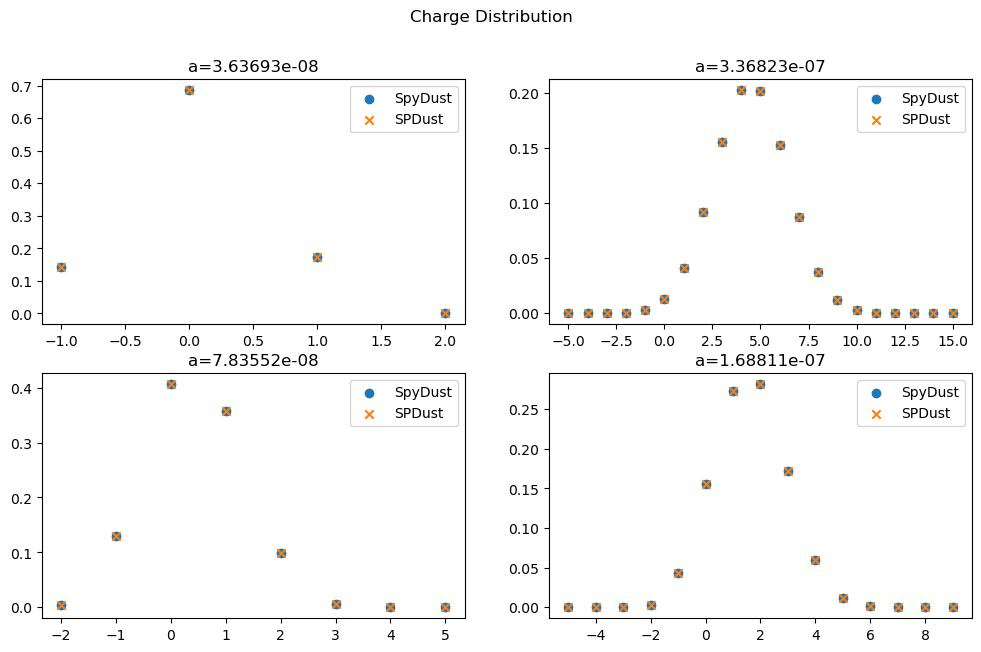

In [7]:
# Compare the charge distribution

fig = plt.figure(figsize=(12, 7))
gs = GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(spy_fZ[0][0, :], spy_fZ[0][1, :], label='SpyDust')
ax1.scatter(SPD_fZ[0][0, :], SPD_fZ[0][1, :], label='SPDust', marker='x')
ax1.title.set_text('a={:2g}'.format(a_tab[0]))

ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(spy_fZ[-1][0, :], spy_fZ[-1][1, :], label='SpyDust')
ax2.scatter(SPD_fZ[-1][0, :], SPD_fZ[-1][1, :], label='SPDust', marker='x')
ax2.title.set_text('a={:2g}'.format(a_tab[-1]))

ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(spy_fZ[10][0, :], spy_fZ[10][1, :], label='SpyDust')
ax3.scatter(SPD_fZ[10][0, :], SPD_fZ[10][1, :], label='SPDust', marker='x')
ax3.title.set_text('a={:2g}'.format(a_tab[10]))

ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(spy_fZ[20][0, :], spy_fZ[20][1, :], label='SpyDust')
ax4.scatter(SPD_fZ[20][0, :], SPD_fZ[20][1, :], label='SPDust', marker='x')
ax4.title.set_text('a={:2g}'.format(a_tab[20]))

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

#plt.title('Charge Distribution')
fig.suptitle('Charge Distribution')
plt.show()


Text(0.5, 1.0, '$\\tau_{\\rm ed}^{-1}$')

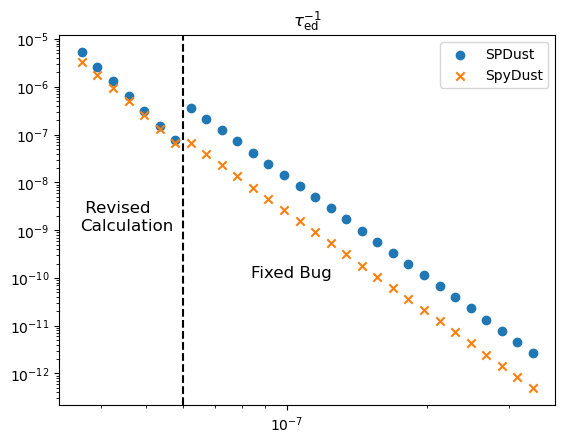

In [14]:
SPD_tau_ed_inv = np.array(SPD_tau_ed_inv)
spy_tau_ed_inv = np.array(spy_tau_ed_inv)
plt.scatter(a_tab, SPD_tau_ed_inv, label='SPDust')
plt.scatter(a_tab, spy_tau_ed_inv, label='SpyDust', lw=1.5, marker='x')
plt.xscale('log')
plt.yscale('log')
# plot vertical line at a2
plt.axvline(a2, color='k', ls='--')
# add text to the left of the line
plt.text(a2*0.6, 1e-9, ' Revised\nCalculation', fontsize=12)
plt.text(a2*1.4, 1e-10, 'Fixed Bug', fontsize=12)
plt.legend()
plt.title(r'$\tau_{\rm ed}^{-1}$')

In [15]:
dip_per_at = WIM_params['dipole'] / np.sqrt(spyGrain.N_C(1e-7) + spyGrain.N_H(1e-7)) * debye

spy_fZ = [spy_charge_dist.charge_dist(WIM_params, a_tab[i], beta_a_list[i]) for i in range(len(a_tab)) ]
spy_Z2 = [np.sum(spy_fZ[i][0, :]**2 * spy_fZ[i][1, :]) for i in range(len(a_tab))]
spy_mu_rms = [spyGrain.rms_dipole(a_tab[i], beta_a_list[i], spy_Z2[i], dip_per_at) for i in range(len(a_tab))]
ip=2/3
mu_ip = [spy_mu_rms[i]*np.sqrt(ip) for i in range(len(a_tab))]
mu_op = [spy_mu_rms[i]*np.sqrt(1-ip) for i in range(len(a_tab))]

### Correction of the plasma drag

In [16]:
from SpyDust.core.plasmadrag import FGp_averaged as spy_FGp_averaged
from SpyDust.SPDUST_as_is.plasmadrag import FGp_averaged as SPD_FGp_averaged
from SpyDust.utils.util import makelogtab

aux_omega_min, aux_omega_max, Nomega = 1e8, 1e15, 1000
aux_omega = makelogtab(aux_omega_min, aux_omega_max, Nomega) 

def plasma_drag_plots(ind):
    aux_spy = spy_FGp_averaged(WIM_params, a_tab[ind], beta_a_list[ind], spy_fZ[ind], aux_omega, mu_ip[ind], mu_op[ind], tumbling=True)
    spy_Fp = aux_spy['Fp']
    spy_Gp = aux_spy['Gp']
    aux_SPD = SPD_FGp_averaged(WIM_params, a_tab[ind], spy_fZ[ind], aux_omega, mu_ip[ind], mu_op[ind], tumbling=True)
    SPD_Fp = aux_SPD['Fp']
    SPD_Gp = aux_SPD['Gp']

    # Compare the plasma drag Fp's and Gp's

    plt.plot(aux_omega, spy_Gp[:,0], label='Gp', ls='-', color='gray', lw=2.5)
    plt.plot(aux_omega, spy_Fp[:,0], label='SpyDust Fp', ls='-', lw=2.5)

    plt.plot(aux_omega, SPD_Fp[:,0], label='SPDust Fp', ls='--', lw=2)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$L/I_3$')
    plt.title('Plasma drag (a={:2g})'.format(a_tab[ind]))
    plt.legend()
    plt.show()
    return

Following the notations and conventions of spdust,
- **Fp** is the scaled rate of **dissipation**
- **Gp** is the scaled rate of **fluctuation**

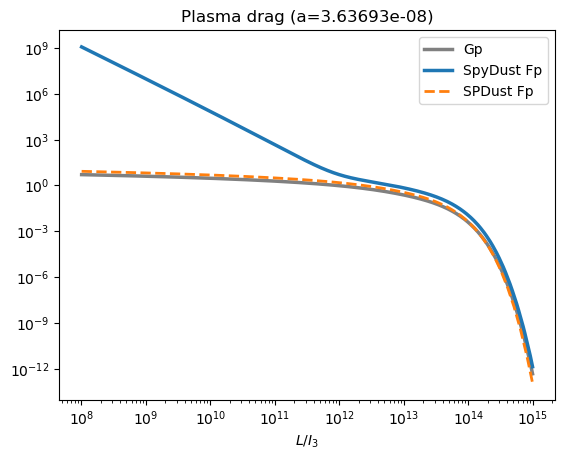

In [17]:
plasma_drag_plots(0)


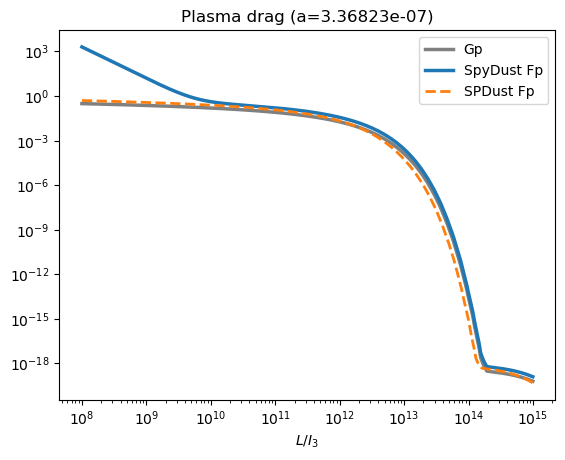

In [18]:
plasma_drag_plots(-1)

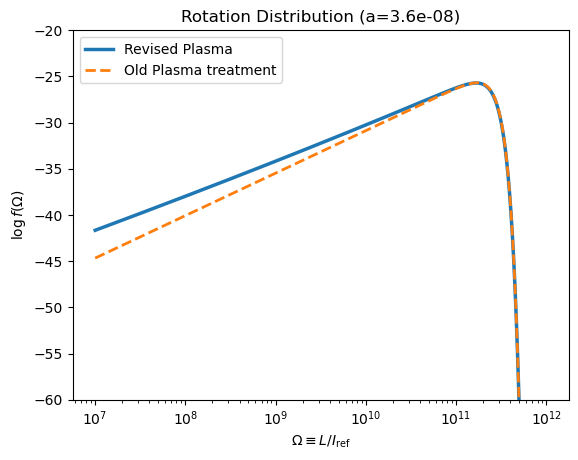

In [19]:
ind = 0
Min_omega, Max_omega = 1e7, 1e12
Myomegas = makelogtab(Min_omega, Max_omega, 1000) 
log_f_omega_new_plasma = spyAngMomDist.log_f_rot(WIM_params, a_tab[ind], beta_a_list[ind], spy_fZ[ind], np.array([mu_ip[ind]]), np.array([mu_op[ind]]), tumbling=True, omega_min=Min_omega, omega_max=Max_omega, Nomega=1000, use_spdust_plasma=False)
log_f_omega_old_plasma = spyAngMomDist.log_f_rot(WIM_params, a_tab[ind], beta_a_list[ind], spy_fZ[ind], np.array([mu_ip[ind]]), np.array([mu_op[ind]]), tumbling=True, omega_min=Min_omega, omega_max=Max_omega, Nomega=1000, use_spdust_plasma=True)

plt.plot(Myomegas, log_f_omega_new_plasma[0], label='Revised Plasma', ls='-', lw=2.5)
plt.plot(Myomegas, log_f_omega_old_plasma[0], label='Old Plasma treatment', ls='--', lw=2)
plt.xscale('log')
plt.ylim(-60, -20)
plt.title(r'Rotation Distribution (a={:.2g})'.format(a_tab[ind]))
plt.xlabel(r'$\Omega\equiv L/I_{\rm ref}$')
plt.ylabel(r'$\log f(\Omega)$')
plt.legend()

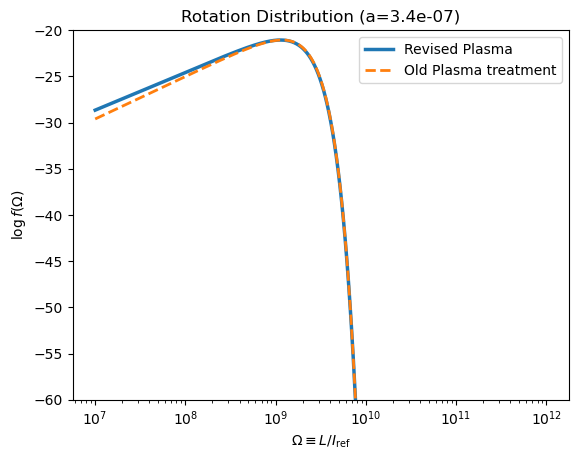

In [20]:
ind = -1
Min_omega, Max_omega = 1e7, 1e12
Myomegas = makelogtab(Min_omega, Max_omega, 1000) 
log_f_omega_new_plasma = spyAngMomDist.log_f_rot(WIM_params, a_tab[ind], beta_a_list[ind], spy_fZ[ind], np.array([mu_ip[ind]]), np.array([mu_op[ind]]), tumbling=True, omega_min=Min_omega, omega_max=Max_omega, Nomega=1000, use_spdust_plasma=False)
log_f_omega_old_plasma = spyAngMomDist.log_f_rot(WIM_params, a_tab[ind], beta_a_list[ind], spy_fZ[ind], np.array([mu_ip[ind]]), np.array([mu_op[ind]]), tumbling=True, omega_min=Min_omega, omega_max=Max_omega, Nomega=1000, use_spdust_plasma=True)

plt.plot(Myomegas, log_f_omega_new_plasma[0], label='Revised Plasma', ls='-', lw=2.5)
plt.plot(Myomegas, log_f_omega_old_plasma[0], label='Old Plasma treatment', ls='--', lw=2)
plt.xscale('log')
plt.ylim(-60, -20)
plt.title(r'Rotation Distribution (a={:.2g})'.format(a_tab[ind]))
plt.xlabel(r'$\Omega\equiv L/I_{\rm ref}$')
plt.ylabel(r'$\log f(\Omega)$')
plt.legend()

### SED before and after these corrections

mu(1E-7 cm) = 9.3 debye (beta = 0.3845076772265463 debye)


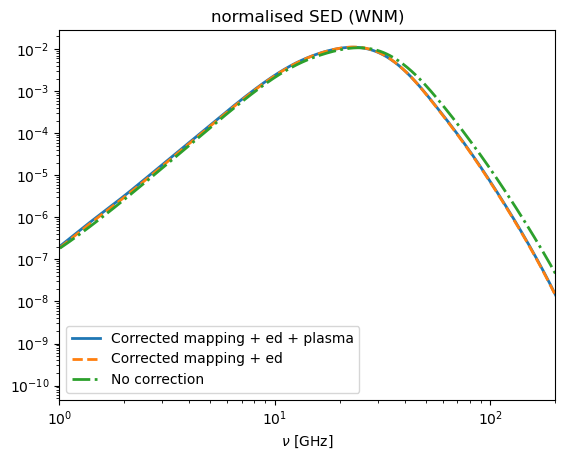

In [ ]:
from SpyDust.main.SpyDust import SpyDust
min_freq=1 # in GHz
max_freq=300 # in GHz
n_freq=500
Spy_SED_old_plasma = SpyDust(WNM_params, min_freq=min_freq, max_freq=max_freq, n_freq=n_freq, single_beta=True, spdust_plasma=True)
Spy_SED_new_plasma = SpyDust(WNM_params, min_freq=min_freq, max_freq=max_freq, n_freq=n_freq, single_beta=True, spdust_plasma=False)
from SpyDust.SPDUST_as_is.spdust import SPDUST
SPD_SED = SPDUST(WNM_params, min_freq = 1, max_freq=300, n_freq=500)

# Two subplots, the axes array is 1-d
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].loglog(Spy_SED_new_plasma[0,:], Spy_SED_new_plasma[1,:], ls='-', lw=2, label='Corrected mapping + ed + plasma')


plt.loglog(Spy_SED_new_plasma[0,:], Spy_SED_new_plasma[1,:]/np.sum(Spy_SED_new_plasma[1,:]), ls='-', lw=2, label='Corrected mapping + ed + plasma')
plt.loglog(Spy_SED_old_plasma[0,:], Spy_SED_old_plasma[1,:]/np.sum(Spy_SED_old_plasma[1,:]), ls='--', lw=2, label='Corrected mapping + ed')
plt.loglog(SPD_SED[0,:], SPD_SED[1,:]/np.sum(SPD_SED[1,:]), ls='-.', lw=2, label='No correction')
plt.xlabel(r'$\nu$ [GHz]')
plt.title('normalised SED (WNM)')
plt.xlim(1, 200)
plt.legend()

mu(1E-7 cm) = 9.3 debye (beta = 0.3845076772265463 debye)


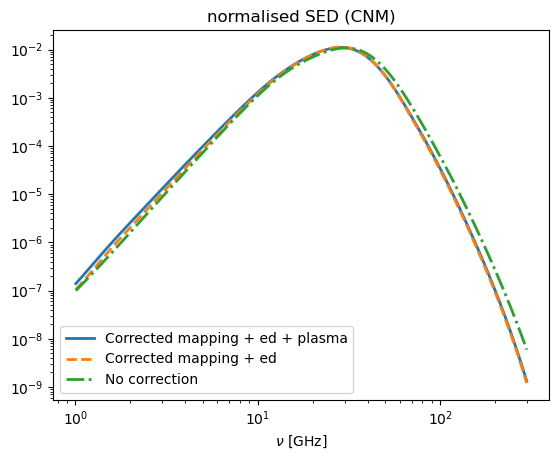

In [23]:
Spy_SED_old_plasma = SpyDust(CNM_params, min_freq=min_freq, max_freq=max_freq, n_freq=n_freq, single_beta=True, spdust_plasma=True)
Spy_SED_new_plasma = SpyDust(CNM_params, min_freq=min_freq, max_freq=max_freq, n_freq=n_freq, single_beta=True, spdust_plasma=False)
SPD_SED = SPDUST(CNM_params, min_freq = 1, max_freq=300, n_freq=500)

plt.loglog(Spy_SED_new_plasma[0,:], Spy_SED_new_plasma[1,:]/np.sum(Spy_SED_new_plasma[1,:]), ls='-', lw=2, label='Corrected mapping + ed + plasma')
plt.loglog(Spy_SED_old_plasma[0,:], Spy_SED_old_plasma[1,:]/np.sum(Spy_SED_old_plasma[1,:]), ls='--', lw=2, label='Corrected mapping + ed')
plt.loglog(SPD_SED[0,:], SPD_SED[1,:]/np.sum(SPD_SED[1,:]), ls='-.', lw=2, label='No correction')
plt.xlabel(r'$\nu$ [GHz]')
plt.title('normalised SED (CNM)')
plt.legend()

In [24]:
Spy_SED_old_plasma = SpyDust(WIM_params, min_freq=min_freq, max_freq=max_freq, n_freq=n_freq, single_beta=True, spdust_plasma=True)
Spy_SED_new_plasma = SpyDust(WIM_params, min_freq=min_freq, max_freq=max_freq, n_freq=n_freq, single_beta=True, spdust_plasma=False)
SPD_SED = SPDUST(WIM_params, min_freq = 1, max_freq=300, n_freq=500)


mu(1E-7 cm) = 9.3 debye (beta = 0.3845076772265463 debye)


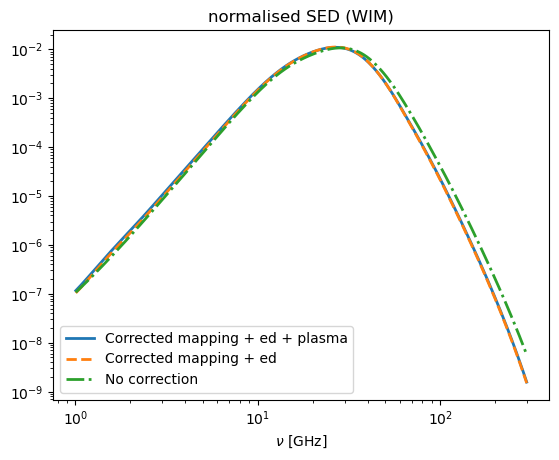

In [25]:

plt.loglog(Spy_SED_new_plasma[0,:], Spy_SED_new_plasma[1,:]/np.sum(Spy_SED_new_plasma[1,:]), ls='-', lw=2, label='Corrected mapping + ed + plasma')
plt.loglog(Spy_SED_old_plasma[0,:], Spy_SED_old_plasma[1,:]/np.sum(Spy_SED_old_plasma[1,:]), ls='--', lw=2, label='Corrected mapping + ed')
plt.loglog(SPD_SED[0,:], SPD_SED[1,:]/np.sum(SPD_SED[1,:]), ls='-.', lw=2, label='No correction')
plt.xlabel(r'$\nu$ [GHz]')
plt.title('normalised SED (WIM)')
plt.legend()

### If we further consider an ensemble of $\beta$, rather than a single $\beta$ for each `a'

In [26]:

Spy_SED_single_beta = SpyDust(WIM_params, min_freq=min_freq, max_freq=max_freq, n_freq=n_freq, single_beta=True, spdust_plasma=False)
Spy_SED_ensemble_beta = SpyDust(WIM_params, min_freq=min_freq, max_freq=max_freq, n_freq=n_freq, single_beta=False, spdust_plasma=False)
SPD_SED = SPDUST(WIM_params, min_freq = 1, max_freq=300, n_freq=500)

mu(1E-7 cm) = 9.3 debye (beta = 0.3845076772265463 debye)


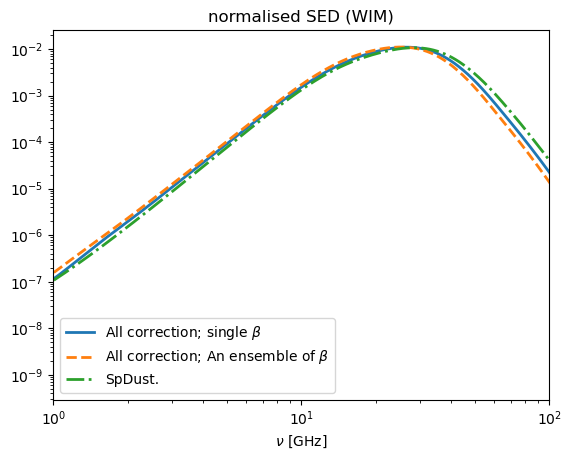

In [27]:

plt.loglog(Spy_SED_single_beta[0,:], Spy_SED_single_beta[1,:]/np.sum(Spy_SED_single_beta[1,:]), ls='-', lw=2, label=r'All correction; single $\beta$')
plt.loglog(Spy_SED_ensemble_beta[0,:], Spy_SED_ensemble_beta[1,:]/np.sum(Spy_SED_ensemble_beta[1,:]), ls='--', lw=2, label=r'All correction; An ensemble of $\beta$')
plt.loglog(SPD_SED[0,:], SPD_SED[1,:]/np.sum(SPD_SED[1,:]), ls='-.', lw=2, label='SpDust.')
plt.xlabel(r'$\nu$ [GHz]')
plt.title('normalised SED (WIM)')
plt.xlim(1, 100)
plt.legend()
